In [1]:
import pandas as pd

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from src.models import SmallNeuralNet
from src.datasets import Tox21Tabular
from src.metrics import recall, precision
from src.transforms import SMILESToMol, MolToRDKitDescriptors
from src.target_transforms import BinaryToxicity

In [2]:
seed = 123
batch_size = 64

In [3]:
df = pd.read_csv("../data/tox21_raw.csv")
print(df.shape)
df.head()

(7817, 14)


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


In [4]:
transform = transforms.Compose(
    [
        SMILESToMol(),
        MolToRDKitDescriptors(),
    ]
)

target_transform = BinaryToxicity()

In [9]:
tox21 = Tox21Tabular(
    csv_path="../data/tox21_raw.csv",
    transform=transform,
    target_transform=target_transform,
)

KeyboardInterrupt: 

In [6]:
generator = torch.Generator().manual_seed(seed)  # needed for reproducibility
train_dataset, test_dataset, val_dataset = random_split(
    tox21, [0.7, 0.2, 0.1], generator=generator
)

In [7]:
len(train_dataset), len(test_dataset), len(val_dataset)

(5365, 1533, 766)

In [8]:
dataloader = DataLoader(tox21, batch_size=2, shuffle=True)

# use a generator to get the first batch
dataloader_iter = iter(dataloader)
batch = next(dataloader_iter)
arr, labels = batch
print(arr.shape, labels)

torch.Size([2, 125]) tensor([1, 1])


[16:39:08] DEPRECATION WARNING: please use MorganGenerator
[16:39:08] DEPRECATION WARNING: please use MorganGenerator
[16:39:08] DEPRECATION WARNING: please use MorganGenerator
[16:39:08] DEPRECATION WARNING: please use MorganGenerator
[16:39:08] DEPRECATION WARNING: please use MorganGenerator
[16:39:08] DEPRECATION WARNING: please use MorganGenerator


In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
neural_net = SmallNeuralNet()
print(neural_net)

SmallNeuralNet(
  (fc1): Linear(in_features=125, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


In [11]:
criterion = torch.nn.BCELoss()  # binary cross entropy loss
optimizer = torch.optim.Adam(neural_net.parameters(), lr=0.001)

In [12]:
# Training loop
num_epochs = 10  # Set the number of epochs
metrics = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": [],
    "val_precision": [],
    "val_recall": [],
}

for epoch in range(num_epochs):
    neural_net.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        labels = labels.unsqueeze(1).float()
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = neural_net(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the weights

        running_loss += loss.item()

    metrics["train_loss"].append(running_loss / len(train_loader))
    print(
        f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader):.5f}"
    )

    # Validation loop
    neural_net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            labels = labels.unsqueeze(1).float()
            outputs = neural_net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Assuming binary classification
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            p = precision(labels, predicted)
            r = recall(labels, predicted)
        metrics["val_loss"].append(val_loss / len(val_loader))
        metrics["val_accuracy"].append(100 * correct / total)
        metrics["val_precision"].append(p / len(val_loader))
        metrics["val_recall"].append(r / len(val_loader))

    print(
        f"Validation Loss: {val_loss/len(val_loader):.5f}, Accuracy: {100 * correct / total:.2f}%, Precision: {p/len(val_loader):.5f}, Recall: {r/len(val_loader):.5f}"
    )

[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerator
[16:39:40] DEPRECATION WARNING: please use MorganGenerat

Epoch 1/10, Training Loss: 0.63146


[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerator
[16:40:59] DEPRECATION WARNING: please use MorganGenerat

Validation Loss: 0.61405, Accuracy: 68.02%, Precision: 0.020833333333333332, Recall: 0.011111111111111112


[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerator
[16:41:10] DEPRECATION WARNING: please use MorganGenerat

Epoch 2/10, Training Loss: 0.59561


[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerator
[16:42:31] DEPRECATION WARNING: please use MorganGenerat

Validation Loss: 0.58225, Accuracy: 70.37%, Precision: 0.020833333333333332, Recall: 0.011111111111111112


[16:42:42] DEPRECATION WARNING: please use MorganGenerator
[16:42:42] DEPRECATION WARNING: please use MorganGenerator
[16:42:42] DEPRECATION WARNING: please use MorganGenerator
[16:42:42] DEPRECATION WARNING: please use MorganGenerator
[16:42:42] DEPRECATION WARNING: please use MorganGenerator
[16:42:42] DEPRECATION WARNING: please use MorganGenerator
[16:42:42] DEPRECATION WARNING: please use MorganGenerator
[16:42:42] DEPRECATION WARNING: please use MorganGenerator
[16:42:42] DEPRECATION WARNING: please use MorganGenerator
[16:42:43] DEPRECATION WARNING: please use MorganGenerator
[16:42:43] DEPRECATION WARNING: please use MorganGenerator
[16:42:43] DEPRECATION WARNING: please use MorganGenerator
[16:42:43] DEPRECATION WARNING: please use MorganGenerator
[16:42:43] DEPRECATION WARNING: please use MorganGenerator
[16:42:43] DEPRECATION WARNING: please use MorganGenerator
[16:42:43] DEPRECATION WARNING: please use MorganGenerator
[16:42:43] DEPRECATION WARNING: please use MorganGenerat

KeyboardInterrupt: 

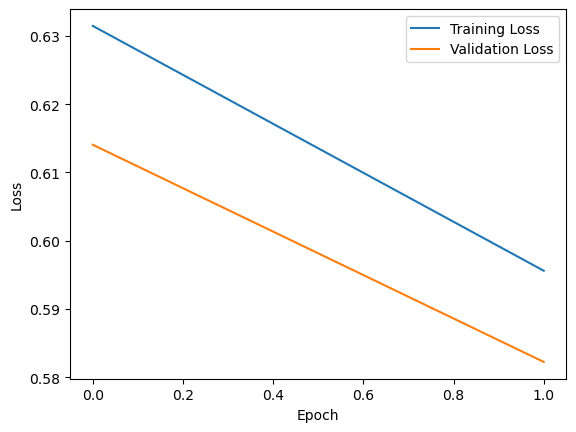

In [13]:
import matplotlib.pyplot as plt

plt.plot(metrics["train_loss"], label="Training Loss")
plt.plot(metrics["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

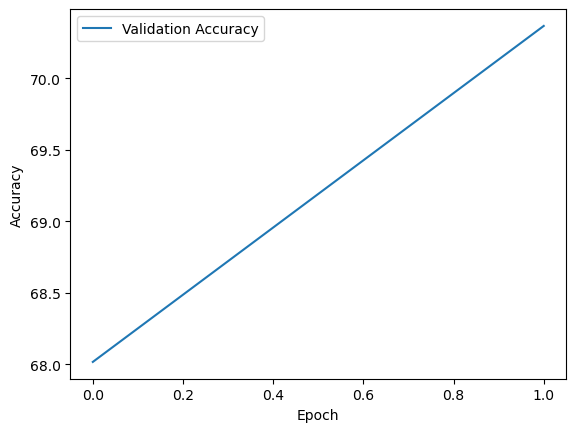

In [14]:
plt.plot(metrics["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

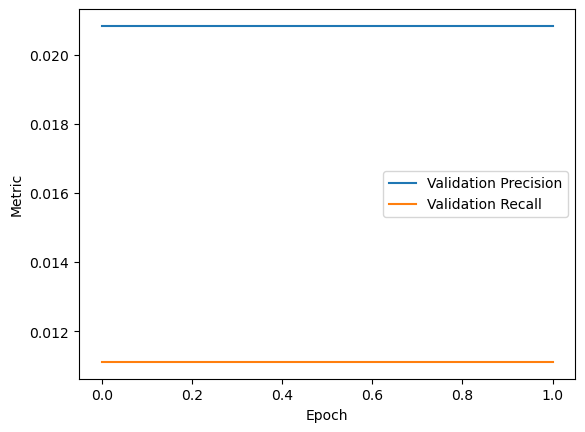

In [15]:
plt.plot(metrics["val_precision"], label="Validation Precision")
plt.plot(metrics["val_recall"], label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.show()